In [461]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import librosa as rosa
import sounddevice as sd
import threading
import os

In [509]:
class audiodata:
    
    def __init__(self, path, data=None, dur=None, sr=None):
        if path != None:
            self.path = path
            self.data, self.sr = rosa.load(path, sr=None)
            self.duration = len(self.data) / self.sr
        else:
            self.path = None
            self.data = data
            self.sr = sr
            self.duration = dur
    
    def plot(self, start=None, stop=None, num_ticks=80):            
        assert stop == None or stop <= start + self.duration
        
        if stop == None:
            stop = self.duration
        
        fig, axs = None, None
        # init plot
        if start == None:
            fig, axs = plt.subplots(figsize=(20, 10))
        else:
            fig, axs = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [2, 10]})
    
        
        if start != None:
            # crop signal
            cropped_data = self.data[int(start * self.sr) : int(stop * self.sr)]
            cropped_duration = len(cropped_data) / self.sr
            cropped_t = np.linspace(start, start + cropped_duration, len(cropped_data))
            
            # x-axis ticks
            axs[0].set_xlabel('time [s]')
            tick_size = self.duration / num_ticks
            ticks = np.arange(0., self.duration + tick_size, tick_size)
            axs[0].set_xticks(ticks)
            plt.setp(axs[0].get_xticklabels(), rotation=90)
            
            # cropped signal x-axis ticks
            axs[1].set_xlabel('time [s]')
            cropped_tick_size = cropped_duration / num_ticks
            cropped_ticks = np.arange(start, start + cropped_duration + cropped_tick_size, cropped_tick_size)
            axs[1].set_xticks(cropped_ticks)
            plt.setp(axs[1].get_xticklabels(), rotation=90)
            
            # title with info
            axs[0].set_title("Duration: %s | Tick size: %s" % (self.duration, tick_size))
            axs[1].set_title("Duration: %s | Tick size: %s" % (cropped_duration, cropped_tick_size))
            
            # red dotted vertical lines at x-axis ticks
            axs[0].grid(True, 'major', 'x', color='r', linestyle='dotted')
            axs[1].grid(True, 'major', 'x', color='r', linestyle='dotted')
            
            # only small margins
            axs[0].margins(x=0.01, y=0.01)
            axs[1].margins(x=0.01, y=0.01)
            
            # plot complete signal
            t = np.linspace(0, self.duration, len(self.data))
            axs[0].plot(t, self.data)
            
            # highlight cropped area
            axs[0].axvspan(start, start + cropped_duration, color='orange', alpha=0.5)
            
            # plot cropped signal
            axs[1].plot(cropped_t, cropped_data)
            
            plt.tight_layout()
            
        else:
            # x-axis ticks
            axs.set_xlabel('time [s]')
            tick_size = self.duration / num_ticks
            ticks = np.arange(0., self.duration + tick_size, tick_size)
            axs.set_xticks(ticks)
            plt.setp(axs.get_xticklabels(), rotation=90)
            
            # title with info
            axs.set_title("Duration: %s | Tick size: %s" % (self.duration, tick_size))
            
            # red dotted vertical lines at x-axis ticks
            axs.grid(True, 'major', 'x', color='r', linestyle='dotted')
           
            # only small margins
            axs.margins(x=0.01, y=0.01)
            
            # plot complete signal
            t = np.linspace(0, self.duration, len(self.data))
            axs.plot(t, self.data)
    
    def play(self, start=0, stop=None):
        assert start >= 0
        assert stop == None or stop <= self.duration
        
        if stop == None:
            stop = self.duration
            
        data = self.data[int(start * self.sr) : int(stop * self.sr)]
        
        sd.play(data, self.sr)
    
    def get_frames(self, frame_length_ms:int = 32, frame_shift_ms:int = 16) -> [np.ndarray, np.ndarray]:
    
        # translate from ms to indices
        frame_length = self.sr * (frame_length_ms / 1000)
        frame_shift = self.sr * (frame_shift_ms / 1000)

        # number of possible frames (w/o padding!)
        num_frames = np.floor((len(self.data) - frame_length) / frame_shift) + 1

        v_time_frame = list()
        m_frames = list()
        for i in np.arange(num_frames):
            # frame center
            v_time_frame.append(((i+1) * frame_length_ms) / 2)

            # crop frame from signal
            frame_start = int(i * frame_shift)
            frame_end = int(i * frame_shift + frame_length)
            m_frames.append(self.data[frame_start : frame_end])

        v_time_frame = np.array(v_time_frame)
        m_frames = np.array(m_frames)

        return v_time_frame, m_frames
    
    def estimate_fundamental_freq(self, frame_length_ms:int = 32, frame_shift_ms:int = 16, min_freq:int = 80, max_freq:int = 400):
        
        # get frames
        v_time_frame, m_frames = self.get_frames(frame_length_ms, frame_shift_ms)
        
        # acf
        res = []
        for frame in m_frames:
            # compute auto-correlation
            acf = np.correlate(frame, frame, 'full')
            acf = acf[acl.size // 2:]
            
            # translate index to ms
            step_ms = frame_length_ms / len(frame)
            # translate min_freq and max_freq to frame indices
            min_freq_idx = (1 / min_freq * 1000) / step_ms
            max_freq_idx = (1 / max_freq * 1000) / step_ms
            
            # find the fundamental period between 80Hz and 400Hz
            fundamental_period_idx = max_freq_idx + np.argmax(acf[int(max_freq_idx) : int(min_freq_idx)])
            
            # compute fundamental freq as reziprocal of the fundamental period
            fundamental_period_ms = (fundamental_period_idx * step_ms) / 1000
            res.append(1 / fundamental_period_ms)
            
        res = np.array(res)
        
        # create plots
        fig, axs = plt.subplots(1, 1, figsize=(20, 10))
        axs2 = axs.twinx()
        
        # x-axis ticks
        num_ticks = 80
        axs.set_xlabel('time [s]')
        tick_size = self.duration / num_ticks
        ticks = np.arange(0., self.duration + tick_size, tick_size)
        axs.set_xticks(ticks)
        plt.setp(axs.get_xticklabels(), rotation=90)

        # title with info
        axs.set_title("Duration: %s[s] | Tick size: %s[s]" % (self.duration, tick_size))

        # red dotted vertical lines at x-axis ticks
        axs.grid(True, 'major', 'x', color='r', linestyle='dotted')

        # only small margins
        axs.margins(x=0.01, y=0.01)
        axs2.margins(x=0.01, y=0.01)
        
        # set plot order
        axs.set_zorder(axs2.get_zorder()+1)
        axs.patch.set_visible(False)
        
        # y-axis ticks
        axs.set_ylabel('Estimated fundamental frequency [Hz]', color='C3')
        ticks = np.arange(0., max(res) + 10, 10)
        axs.set_yticks(ticks)
        axs2.set_ylabel('Signal s(t)', color='C0')
        
        # plot estimated fundamental freqs
        t = np.linspace(0, self.duration, len(res))
        axs.plot(t, res, color='C3')
        
        # plot complete signal
        t2 = np.linspace(0, self.duration, len(self.data))
        axs2.plot(t2, self.data, color='C0')
        
        return res
    
    def get_cropped(self, start, stop):
        cropped_data = self.data[int(start * self.sr) : int(stop * self.sr)]
        cropped_duration = len(cropped_data) / self.sr
        return audiodata(None, cropped_data, cropped_duration, self.sr)

In [510]:
speech1_file = os.getcwd() + "/AudioFiles/speech1.wav"
speech2_file = os.getcwd() + "/AudioFiles/speech2.wav"
speech1 = audiodata(speech1_file)
speech2 = audiodata(speech2_file)

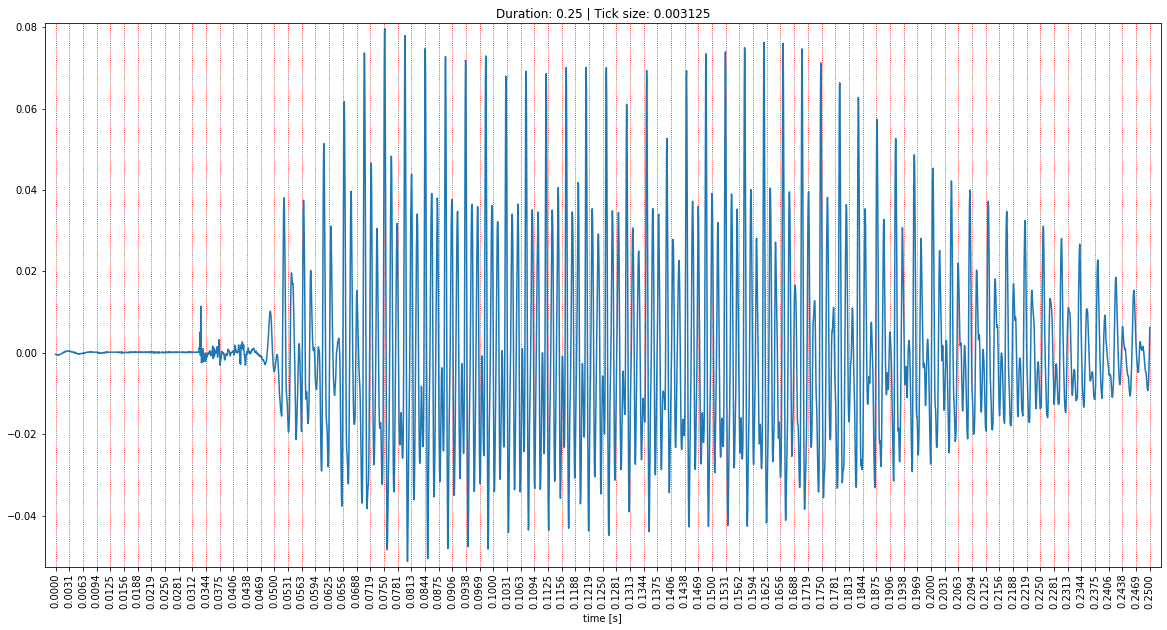

In [511]:
speech3 = speech1.get_cropped(0.25, 0.5)
speech3.plot()

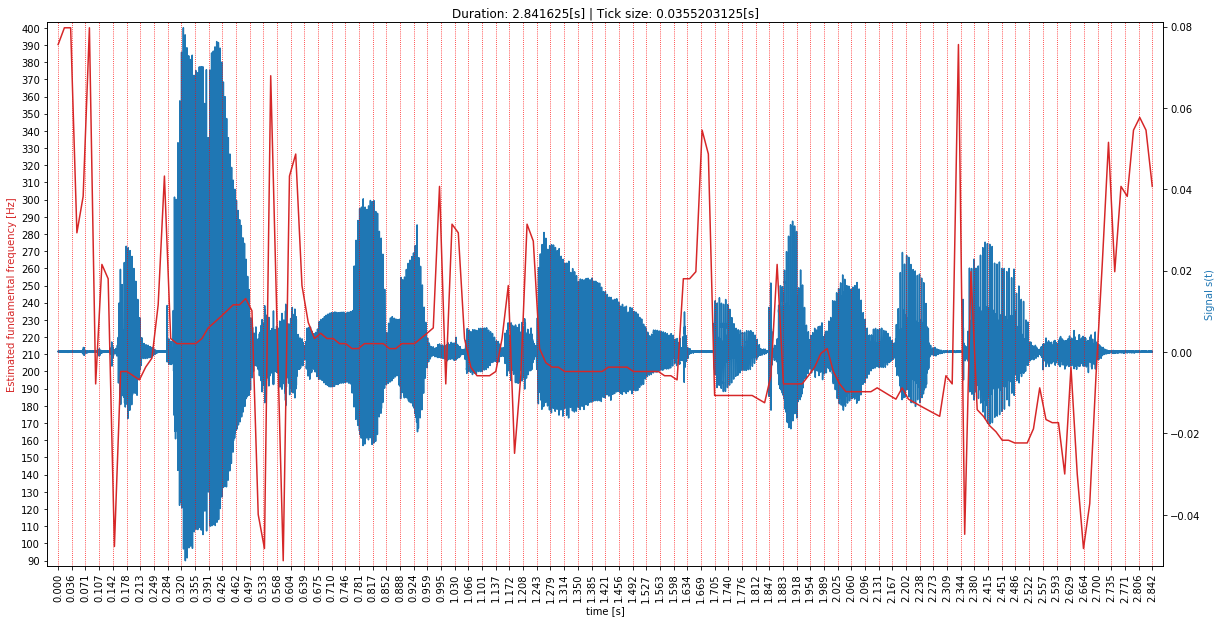

In [512]:
a = speech1.estimate_fundamental_freq()

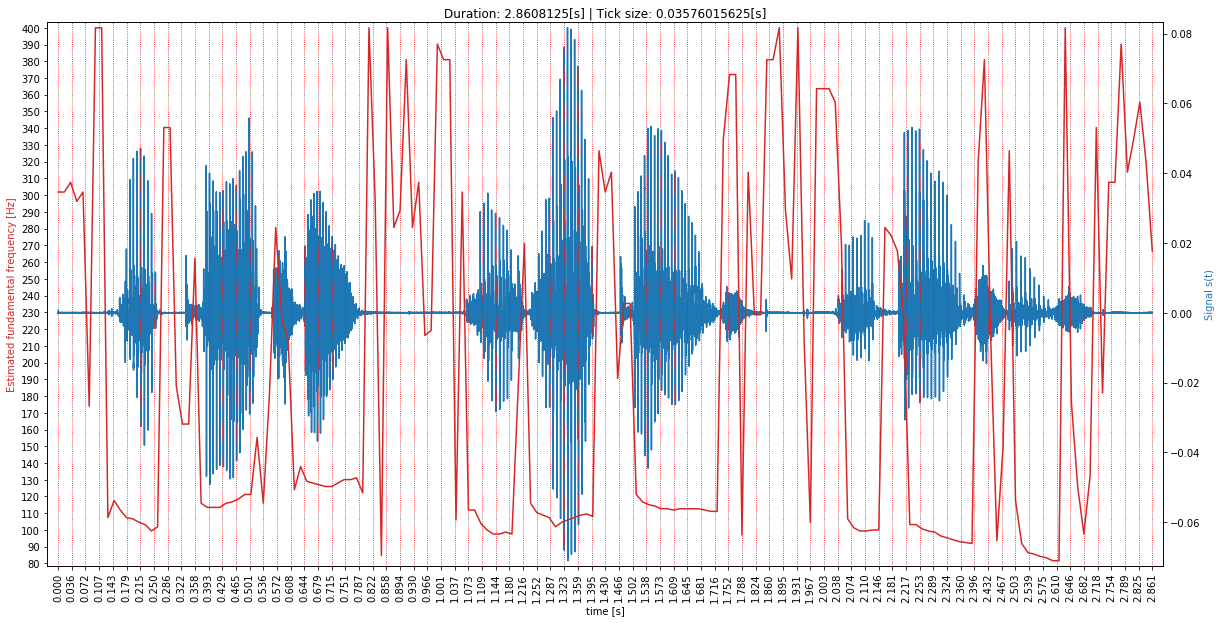

In [513]:
a = speech2.estimate_fundamental_freq()

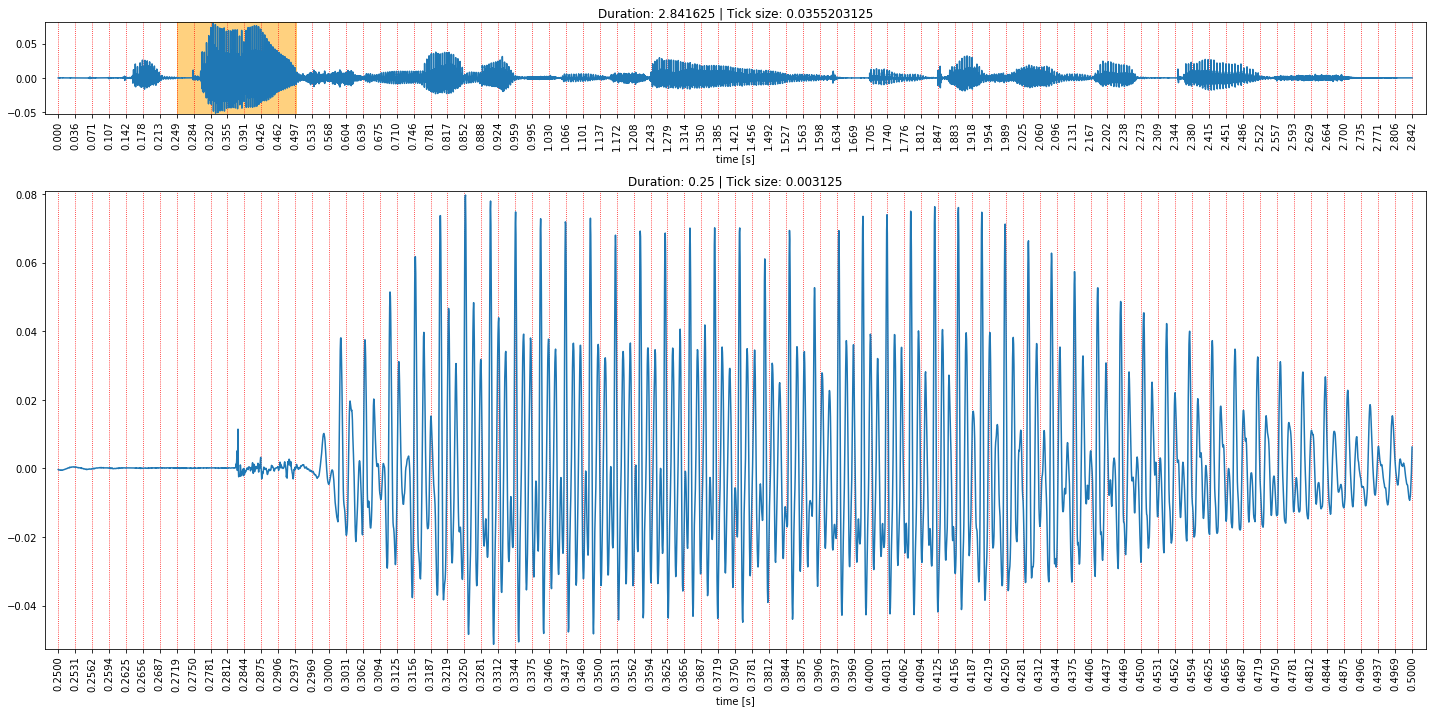

In [180]:
speech1.plot(0.250, 0.5)

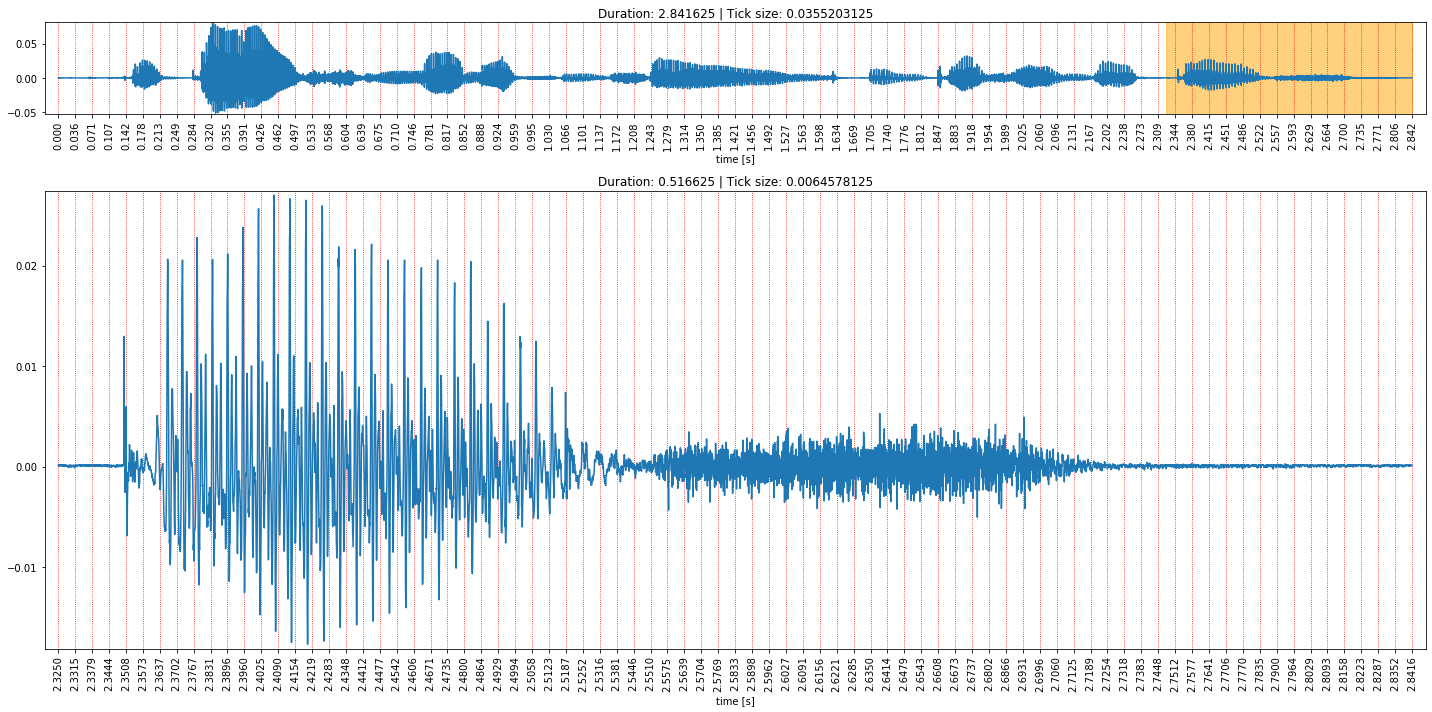

In [8]:
speech1.plot(2.325)

In [9]:
speech1.play(2.36, 2.53)

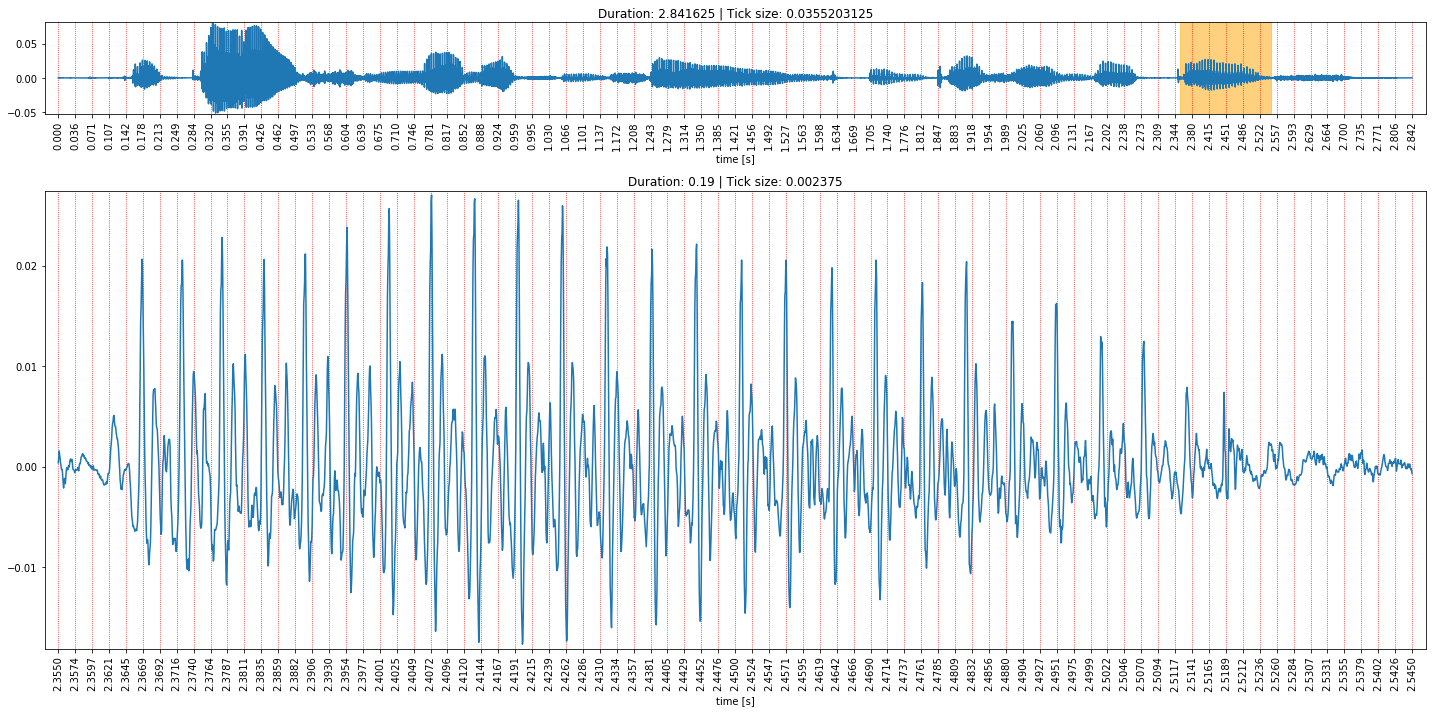

In [10]:
speech1.plot(2.355, 2.545)

In [11]:
1 / ((2.4191 - 2.3669) / 10)

191.57088122605356

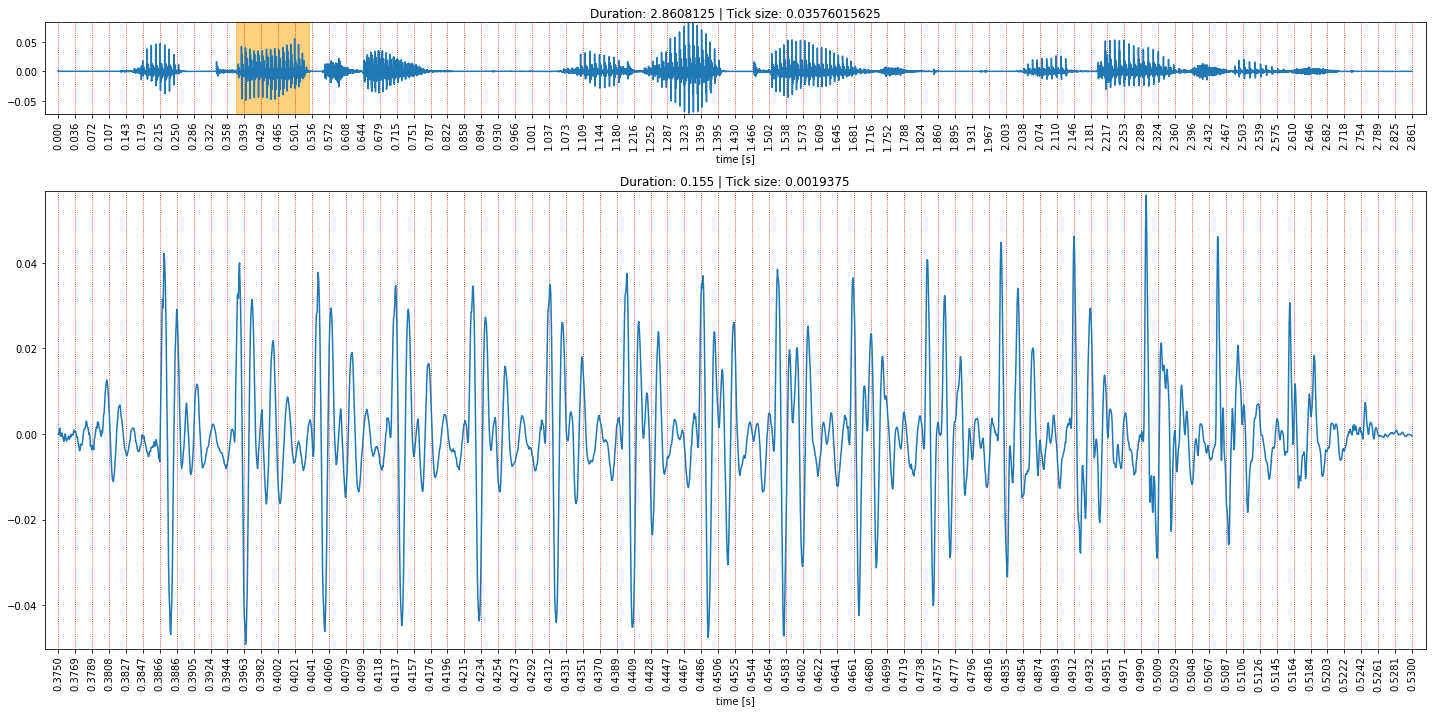

In [12]:
speech2.plot(0.375,0.530)

In [13]:
speech2.play(0.375,0.530)

In [14]:
1 / ((0.4740 - 0.3865) / 10)

114.28571428571432

In [15]:
def get_frames(data : np.ndarray, sampling_rate : int, frame_length_ms : int, frame_shift_ms : int) -> [np.ndarray, np.ndarray]:
    
    # translate from ms to indices
    frame_length = sampling_rate * (frame_length_ms / 1000)
    frame_shift = sampling_rate * (frame_shift_ms / 1000)
    
    # number of possible frames (w/o padding!)
    num_frames = np.floor((len(data) - frame_length) / frame_shift) + 1
    
    v_time_frame = list()
    m_frames = list()
    for i in np.arange(num_frames):
        # frame center
        v_time_frame.append(((i+1) * frame_length_ms) / 2)
        
        # crop frame from signal
        frame_start = int(i * frame_shift)
        frame_end = int(i * frame_shift + frame_length)
        m_frames.append(data[frame_start : frame_end])
    
    v_time_frame = np.array(v_time_frame)
    m_frames = np.array(m_frames)
    
    return v_time_frame, m_frames


In [114]:
v_time_frame, m_frames = speech1.get_frames(32, 16)
print(m_frames.shape)
print(v_time_frame.shape)

(176, 512)
(176,)


135573.46262626263

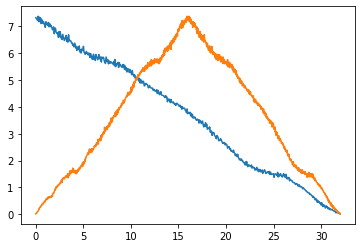

In [115]:
conv = np.convolve(m_frames[0, :], m_frames[0, :])
x = np.linspace(0, 32, 512)
plt.plot(x, conv[conv.size // 2:] * 1000000)
x = np.linspace(0, 32, len(conv))
plt.plot(x, conv * 1000000)

1 / max(conv[conv.size // 2:])

176


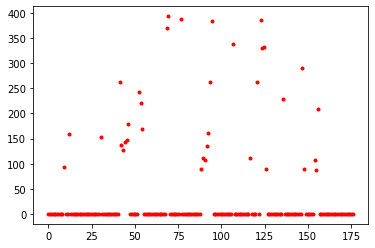

In [117]:
res = []
for frame in m_frames:
    acl = np.convolve(frame, frame) #* (1/len(frame))
    res.append(1 / max(acl[acl.size // 2:]))

res = np.array(res)
res[res > 400] = 0
res[res < 80] = 0
print(len(m_frames))
#print(res)
x = np.linspace(0, len(m_frames), len(m_frames))

plt.scatter(x, res, color='r', marker='.')